In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import torch
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import Flatten, Sequential, Linear, Softmax, BatchNorm1d, Identity

import netCDF4 as nc
masked_cmap = matplotlib.cm.bwr
masked_cmap.set_bad('black', 0.5)

/home/niyiyu/anaconda3/envs/seisml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## preparing data

In [110]:
## the weekly mean sea surface temperature could be downloaded at 
## https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html
## sst.wkmean.1990-present.nc

d = nc.Dataset("../data/sst.wkmean.1990-present.nc")
data = d['sst'][:1400, :, :]

# # np.save("../data/sst.filter", ?data)
# with open('../data/sst.filter.bin', 'wb') as f:
#     pickle.dump( data, f)

In [111]:
# import netCDF4 as nc
l = nc.Dataset("../data/lsmask.nc")
mask = l['mask'][0, :, :]
# mask_index = np.where(np.array(mask.astype('int'))>0)
# with open('../data/landmask.filter.bin', 'wb') as f:
#     pickle.dump(mask_index, f)

In [112]:
# with open('../data/sst.filter.bin', 'rb') as f:
#     data = pickle.load(f)
# with open('../data/landmask.filter.bin', 'rb') as f:
#     idx_r, idx_c = pickle.load(f)

In [113]:
# raw = np.zeros([1400, 44219])
# for i in range(1400):
#     raw[i, :] = np.array(data[i, idx_r, idx_c]).flatten()
# with open('../data/raw.bin', 'wb') as f:
#     pickle.dump(raw, f)

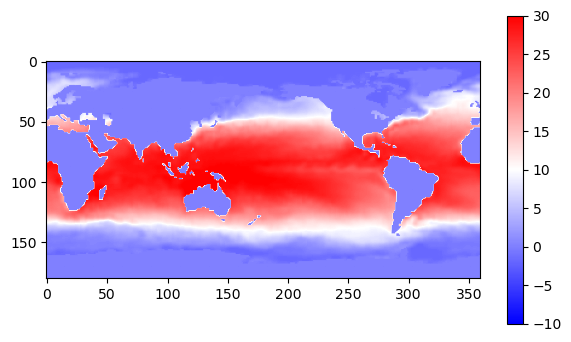

In [114]:
plt.figure(figsize = (7, 4), dpi = 100)
plt.imshow(data[1200, :, :]*mask, cmap = masked_cmap, vmin = -10, vmax = 30)
plt.colorbar()

## prepare model

In [2]:
with open('../data/landmask.filter.bin', 'rb') as f:
    idx_r, idx_c = pickle.load(f)
    
with open('../data/raw.bin', 'rb') as f:
    raw = pickle.load(f)
# raw -= raw.min()
# raw /= raw.max()
print(raw.shape, raw.min(), raw.max())

(1400, 44219) -1.7999999523162842 35.630001068115234


In [3]:
class SeaDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, outputs):
        'Initialization'
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.outputs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.inputs[index, :]
        y = self.outputs[index, :]

        return X, y

In [4]:
class SND(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ln1 = Linear(2000, 350)
        self.ln2 = Linear(350, 400)
        self.ln3 = Linear(400, 44219)
        self.bn1 = BatchNorm1d(350)
        self.bn2 = BatchNorm1d(400)
        self.activate = torch.relu
#         self.softmax = Softmax()
        
    def forward(self, x):
        x = x.float()
        x = self.bn1(self.activate(self.ln1(x)))
        x = self.bn2(self.activate(self.ln2(x)))
        x = self.ln3(x)
        return x

In [5]:
device = torch.device('cuda')
model = SND()
model.to(device);

SND(
  (ln1): Linear(in_features=2000, out_features=350, bias=True)
  (ln2): Linear(in_features=350, out_features=400, bias=True)
  (ln3): Linear(in_features=400, out_features=44219, bias=True)
  (bn1): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [6]:
batch_size = 16

train_index = np.random.choice(np.arange(1400), 1000, replace = False)
val_index = np.setdiff1d(np.arange(1400), train_index)

input_index = np.random.choice(np.arange(44219), 2000, replace = False)

train_data_output = raw[train_index, :]
train_data_input = train_data_output[:, input_index]
val_data_output = raw[val_index, :]
val_data_input = val_data_output[:, input_index]

train_dataset = SeaDataset(train_data_input, train_data_output)
val_dataset = SeaDataset(val_data_input, val_data_output)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=5)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=5)

In [67]:
def loss_fn(y_pred, y_true):
    mis = torch.norm(y_pred - y_true, dim = 1)
    mis /= torch.norm(y_true, dim = 1)
    mis = torch.mean(mis)
    return mis

nsensor = 2000
n_mute_sensors = np.array([0, 1000, 1500, 1750, 1900, 1955, 1965, 1972, 1978, 1984, 
                      1987, 1990, 1992, 1994, 1996, 1997, 1998, 1999])
n_sensors = nsensor - n_mute_sensors

val_losses = {}
for experiment in range(30):
    print(f"test {experiment}")
    mute_sensor = {}
    val_losses[experiment] = []
    
    for nmask in n_mute_sensors:
        sparsity = nmask / nsensor
#         print("sparsity %.3f%%"  % (sparsity*100))
        model = SND()
        device = torch.device('cuda')
        model.to(device)
    #     break

        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

        if nmask > 0:
            idx = rms.argsort()[:nmask]
            mask = torch.Tensor(np.ones([350, 2000])).to(device)
            mask[:, idx] = 0
            mute_sensor[nmask] = idx
            print(f"pruning {len(idx)} sensors")
            torch.nn.utils.prune.custom_from_mask(model.ln1, name="weight", mask = mask)
        else:
            print("initial model. no pruning")

        patient = 5
        trigger = 0
        min_val_loss = 999999
        for t in range(50):
#             print(f"Epoch {t+1}\n-------------------------------")
            ## train
            model.train()
            train_loss = 0
            for batch_id, batch in enumerate(train_loader):
                pred = model(batch[0].to(device))
                loss = loss_fn(pred, batch[1].to(device))
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)

            ## validate
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_id, batch in enumerate(val_loader):
                    pred = model(batch[0].to(device))
                    loss = loss_fn(pred, batch[1].to(device))
                    val_loss += loss.item()
            val_loss /= len(val_loader)

#             print("%.4f, %.4f | patient %d"  % (train_loss, val_loss, trigger + 1))
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                trigger = 0
            else:
                trigger += 1
                if trigger == patient:
                    val_losses[experiment].append(min_val_loss)
                    print("Early stop reached. Break.")
                    break

        weight = model.ln1.weight.detach().cpu().numpy()
        rms = np.sqrt(np.mean(weight**2, axis = 0))

test 0
initial model. no pruning
Early stop reached. Break.
pruning 1000 sensors
Early stop reached. Break.
pruning 1500 sensors
Early stop reached. Break.
pruning 1750 sensors
Early stop reached. Break.
pruning 1900 sensors
Early stop reached. Break.
pruning 1955 sensors
Early stop reached. Break.
pruning 1965 sensors
Early stop reached. Break.
pruning 1972 sensors
Early stop reached. Break.
pruning 1978 sensors
Early stop reached. Break.
pruning 1984 sensors
Early stop reached. Break.
pruning 1987 sensors
Early stop reached. Break.
pruning 1990 sensors
Early stop reached. Break.
pruning 1992 sensors
Early stop reached. Break.
pruning 1994 sensors
Early stop reached. Break.
pruning 1996 sensors
Early stop reached. Break.
pruning 1997 sensors
Early stop reached. Break.
pruning 1998 sensors
Early stop reached. Break.
pruning 1999 sensors
Early stop reached. Break.
test 1
initial model. no pruning
Early stop reached. Break.
pruning 1000 sensors
Early stop reached. Break.
pruning 1500 sen

Early stop reached. Break.
pruning 1972 sensors
Early stop reached. Break.
pruning 1978 sensors
Early stop reached. Break.
pruning 1984 sensors
Early stop reached. Break.
pruning 1987 sensors
Early stop reached. Break.
pruning 1990 sensors
Early stop reached. Break.
pruning 1992 sensors
Early stop reached. Break.
pruning 1994 sensors
Early stop reached. Break.
pruning 1996 sensors
Early stop reached. Break.
pruning 1997 sensors
Early stop reached. Break.
pruning 1998 sensors
Early stop reached. Break.
pruning 1999 sensors
Early stop reached. Break.
test 10
initial model. no pruning
Early stop reached. Break.
pruning 1000 sensors
Early stop reached. Break.
pruning 1500 sensors
Early stop reached. Break.
pruning 1750 sensors
Early stop reached. Break.
pruning 1900 sensors
Early stop reached. Break.
pruning 1955 sensors
Early stop reached. Break.
pruning 1965 sensors
Early stop reached. Break.
pruning 1972 sensors
Early stop reached. Break.
pruning 1978 sensors
Early stop reached. Break.


Early stop reached. Break.
pruning 1996 sensors
Early stop reached. Break.
pruning 1997 sensors
Early stop reached. Break.
pruning 1998 sensors
Early stop reached. Break.
pruning 1999 sensors
Early stop reached. Break.
test 19
initial model. no pruning
Early stop reached. Break.
pruning 1000 sensors
Early stop reached. Break.
pruning 1500 sensors
Early stop reached. Break.
pruning 1750 sensors
Early stop reached. Break.
pruning 1900 sensors
Early stop reached. Break.
pruning 1955 sensors
Early stop reached. Break.
pruning 1965 sensors
Early stop reached. Break.
pruning 1972 sensors
Early stop reached. Break.
pruning 1978 sensors
Early stop reached. Break.
pruning 1984 sensors
Early stop reached. Break.
pruning 1987 sensors
Early stop reached. Break.
pruning 1990 sensors
Early stop reached. Break.
pruning 1992 sensors
Early stop reached. Break.
pruning 1994 sensors
Early stop reached. Break.
pruning 1996 sensors
Early stop reached. Break.
pruning 1997 sensors
Early stop reached. Break.


Early stop reached. Break.
pruning 1750 sensors
Early stop reached. Break.
pruning 1900 sensors
Early stop reached. Break.
pruning 1955 sensors
Early stop reached. Break.
pruning 1965 sensors
Early stop reached. Break.
pruning 1972 sensors
Early stop reached. Break.
pruning 1978 sensors
Early stop reached. Break.
pruning 1984 sensors
Early stop reached. Break.
pruning 1987 sensors
Early stop reached. Break.
pruning 1990 sensors
Early stop reached. Break.
pruning 1992 sensors
Early stop reached. Break.
pruning 1994 sensors
Early stop reached. Break.
pruning 1996 sensors
Early stop reached. Break.
pruning 1997 sensors
Early stop reached. Break.
pruning 1998 sensors
Early stop reached. Break.
pruning 1999 sensors
Early stop reached. Break.
test 29
initial model. no pruning
Early stop reached. Break.
pruning 1000 sensors
Early stop reached. Break.
pruning 1500 sensors
Early stop reached. Break.
pruning 1750 sensors
Early stop reached. Break.
pruning 1900 sensors
Early stop reached. Break.


(0.0, 50.0)

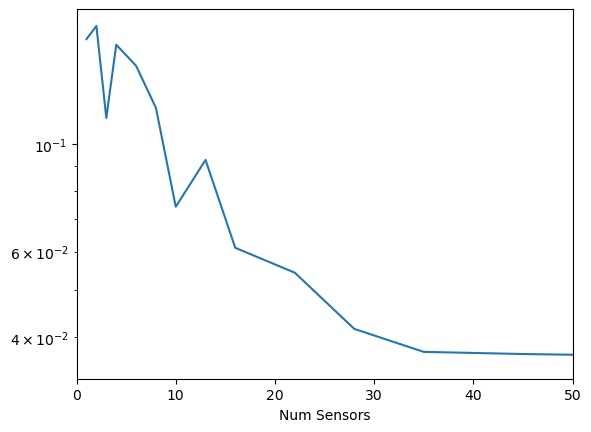

In [66]:
record = np.array(list(val_losses.values())[:-1])
plt.errorbar(n_sensors, np.mean(record, axis = 0))
plt.xlabel("Num Sensors")
plt.ylabel("Reconstruction Error")
plt.yscale('log')
plt.xlim([0, 50])

## snapshot test

In [92]:
val_losses[experiment] = []
n_mute_sensors = np.array([0, 1000, 1500, 1750, 1900, 1955, 1965, 1972, 1978])
for nmask in n_mute_sensors:
    sparsity = nmask / nsensor
#         print("sparsity %.3f%%"  % (sparsity*100))
    model = SND()
    device = torch.device('cuda')
    model.to(device)
#     break

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

    if nmask > 0:
        idx = rms.argsort()[:nmask]
        mask = torch.Tensor(np.ones([350, 2000])).to(device)
        mask[:, idx] = 0
        mute_sensor[nmask] = idx
        print(f"pruning {len(idx)} sensors")
        torch.nn.utils.prune.custom_from_mask(model.ln1, name="weight", mask = mask)
    else:
        print("initial model. no pruning")

    patient = 5
    trigger = 0
    min_val_loss = 999999
    for t in range(50):
#             print(f"Epoch {t+1}\n-------------------------------")
        ## train
        model.train()
        train_loss = 0
        for batch_id, batch in enumerate(train_loader):
            pred = model(batch[0].to(device))
            loss = loss_fn(pred, batch[1].to(device))
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        ## validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_id, batch in enumerate(val_loader):
                pred = model(batch[0].to(device))
                loss = loss_fn(pred, batch[1].to(device))
                val_loss += loss.item()
        val_loss /= len(val_loader)

#             print("%.4f, %.4f | patient %d"  % (train_loss, val_loss, trigger + 1))
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            trigger = 0
        else:
            trigger += 1
            if trigger == patient:
                val_losses[experiment].append(min_val_loss)
                print("Early stop reached. Break.")
                break

initial model. no pruning
Early stop reached. Break.
pruning 1000 sensors
Early stop reached. Break.
pruning 1500 sensors
Early stop reached. Break.
pruning 1750 sensors
Early stop reached. Break.
pruning 1900 sensors
Early stop reached. Break.
pruning 1955 sensors
Early stop reached. Break.
pruning 1965 sensors
Early stop reached. Break.
pruning 1972 sensors
Early stop reached. Break.
pruning 1978 sensors
Early stop reached. Break.


In [115]:
idx = 1
model.eval()
val_data_sample_input = val_data_input[idx, :]
val_data_sample_input = np.expand_dims(val_data_sample_input, axis = 0)
val_data_sample_output = val_data_output[idx, :]
val_data_predict = model(torch.Tensor(val_data_sample_input).to(device)).detach().cpu().numpy()[0, :]

In [116]:
pred = np.empty([180, 360]); pred[:] = np.nan
true = np.empty([180, 360]); true[:] = np.nan

for r, c, d in zip(idx_r, idx_c, val_data_predict):
    pred[r, c] = d
for r, c, d in zip(idx_r, idx_c, val_data_sample_output):
    true[r, c] = d
    
masked_pred = np.ma.array(pred, mask=np.isnan(pred))
masked_true = np.ma.array(true, mask=np.isnan(true))

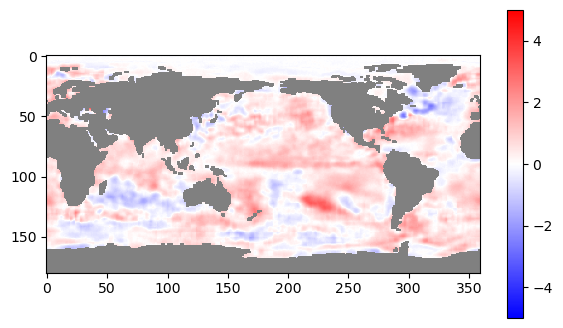

In [118]:
plt.figure(figsize = (7, 4), dpi = 100)


plt.imshow(masked_true - masked_pred, cmap = masked_cmap, vmin = -5, vmax = 5)

plt.colorbar()